In [1]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

folder_path = '../models/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

from cnep import CNEP
from cnmp import CNMP

torch.set_float32_matmul_precision('high')

def get_free_gpu():
    gpu_util = []
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)  # Switch GPU
#        gpu_util.append((i, torch.cuda.memory_stats()['reserved_bytes.all.current'] / (1024 ** 2)))
        gpu_util.append((i, torch.cuda.utilization()))
    gpu_util.sort(key=lambda x: x[1])
    return gpu_util[0][0]

if torch.cuda.is_available():
    available_gpu = get_free_gpu()
    if available_gpu == 0:
        device = torch.device("cuda:0")
    else:
        device = torch.device(f"cuda:{available_gpu}")
else:
    device = torch.device("cpu")

print("Device :", device)

Device : cuda:0


In [2]:
import math

num_demos, v_num_demos = 128, 32
x = torch.linspace(0, 1, 200).repeat(num_demos, 1).unsqueeze(-1)
vx = torch.linspace(0, 1, 200).repeat(v_num_demos, 1).unsqueeze(-1)
y = torch.zeros((num_demos, x.shape[1], 1))
vy = torch.zeros((v_num_demos, vx.shape[1], 1))

frequencies = [1, 2.5, 4, 5.5]  # Example frequencies
amplitudes = [1.5, 1, 0.8, 0.6]  # Example amplitudes
phases = [0, torch.pi / 2, torch.pi, 3 * torch.pi / 2]  # Example phases


for i in range(num_demos):
    y[i, :, 0] = amplitudes[i%2] * torch.sin(2 * torch.pi * frequencies[i%2] * x[i, :, 0] + phases[i%2]) + torch.randn(1) * 0.05
for i in range(v_num_demos):
    vy[i, :, 0] = amplitudes[i%2] * torch.sin(2 * torch.pi * frequencies[i%2] * vx[i, :, 0] + phases[i%2]) + torch.randn(1) * 0.05

print(x.shape, y.shape)
print(vx.shape, vy.shape)

torch.Size([128, 200, 1]) torch.Size([128, 200, 1])
torch.Size([32, 200, 1]) torch.Size([32, 200, 1])


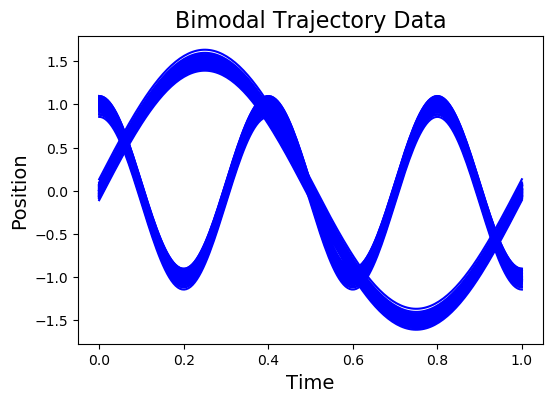

In [3]:
plt.figure(figsize=(6, 4))
# plt.plot(x, y, label='Original Noisy Data', color='gray')
plt.plot(x[0,:], y[:,:,0].T, color='blue')
plt.xlabel("Time", fontsize=14)
plt.ylabel("Position", fontsize=14)
plt.title("Bimodal Trajectory Data", fontsize=16)
plt.show()

In [4]:
# Hyperparameters
batch_size = 32
n_max, m_max = 10, 10

t_steps = 200
num_demos = 128
num_classes = 4
num_indiv = num_demos//num_classes  # number of demos per class
dx, dy = 1, 1

num_val = 32
num_val_indiv = num_val//num_classes

colors = [sns.color_palette('tab10')[0], sns.color_palette('tab10')[1], sns.color_palette('tab10')[2], sns.color_palette('tab10')[3]]
sns.set_palette('tab10')

In [5]:
x, y = x.to(device), y.to(device)
print(x.shape, y.shape)

torch.Size([128, 200, 1]) torch.Size([128, 200, 1])


In [6]:
obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
tar_x = torch.zeros((batch_size, m_max, dx), dtype=torch.float32, device=device)
tar_y = torch.zeros((batch_size, m_max, dy), dtype=torch.float32, device=device)
obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)
tar_mask = torch.zeros((batch_size, m_max), dtype=torch.bool, device=device)

def prepare_masked_batch(t: list, traj_ids: list):
    obs.fill_(0)
    tar_x.fill_(0)
    tar_y.fill_(0)
    obs_mask.fill_(False)
    tar_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = torch.randint(1, n_max, (1,)).item()
        m = torch.randint(1, m_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = permuted_ids[n:n+m]
        
        obs[i, :n, :dx] = (n_ids/t_steps).unsqueeze(1)  # X
        obs[i, :n, dx:] = traj[n_ids]  # Y
        obs_mask[i, :n] = True
        
        tar_x[i, :m] = (m_ids/t_steps).unsqueeze(1)
        tar_y[i, :m] = traj[m_ids]
        tar_mask[i, :m] = True

val_obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dx), dtype=torch.float32, device=device)
val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

def prepare_masked_val_batch(t: list, traj_ids: list):
    val_obs.fill_(0)
    val_tar_x.fill_(0)
    val_tar_y.fill_(0)
    val_obs_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = torch.randint(1, n_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = torch.arange(t_steps)
        
        val_obs[i, :n, :dx] = (n_ids/t_steps).unsqueeze(1)
        val_obs[i, :n, dx:] = traj[n_ids]
        val_obs_mask[i, :n] = True
        
        val_tar_x[i] = (m_ids/t_steps).unsqueeze(1)
        val_tar_y[i] = traj[m_ids]

In [10]:
cnep_ = CNEP(1, 1, n_max, m_max, [128,128], num_decoders=2, decoder_hidden_dims=[128, 128], batch_size=batch_size, scale_coefs=True, device=device)
optimizer_cnep = torch.optim.Adam(lr=1e-4, params=cnep_.parameters())

# CNP(input_dim=1, hidden_dim=204, output_dim=1, n_max_obs=6, n_max_tar=6, num_layers=3, batch_size=batch_size).to(device)
cnmp_ = CNMP(1, 1, n_max, m_max, [160,160], decoder_hidden_dims=[160,160], batch_size=batch_size, device=device)
optimizer_cnmp = torch.optim.Adam(lr=1e-4, params=cnmp_.parameters())

def get_parameter_count(model):
    total_num = 0
    for param in model.parameters():
        total_num += param.shape.numel()
    return total_num

print("cnep:", get_parameter_count(cnep_), 'cnmp:', get_parameter_count(cnmp_))

if torch.__version__ >= "2.0":
    cnep, cnmp = torch.compile(cnep_), torch.compile(cnmp_)
else:
    cnep, cnmp = cnep_, cnmp_

cnep: 50950 cnmp: 52482


In [8]:
import time
import os

timestamp = int(time.time())
root_folder = f'../outputs/sine/bimodal/cnmp_cnep/{str(timestamp)}/'

if not os.path.exists(root_folder):
    os.makedirs(root_folder)

if not os.path.exists(f'{root_folder}saved_models/'):
    os.makedirs(f'{root_folder}saved_models/')

if not os.path.exists(f'{root_folder}img/'):
    os.makedirs(f'{root_folder}img/')

torch.save(y, f'{root_folder}y.pt')


epochs = 1_000_000
epoch_iter = num_demos//batch_size  # number of batches per epoch (e.g. 100//32 = 3)
v_epoch_iter = num_val//batch_size  # number of batches per validation (e.g. 100//32 = 3)
avg_loss_cnmp, avg_loss_cnep = 0, 0

val_per_epoch = 1000
min_vl_cnmp, min_vl_cnep = 1000000, 1000000

mse_loss = torch.nn.MSELoss()

tl_cnmp, tl_cnep = [], []
ve_cnmp, ve_cnep = [], []

cnmp_tl_path, cnep_tl_path = f'{root_folder}cnmp_training_loss.pt', f'{root_folder}cnep_training_loss.pt'
cnmp_ve_path, cnep_ve_path = f'{root_folder}cnmp_validation_error.pt', f'{root_folder}cnep_validation_error.pt'

for epoch in range(epochs):
    epoch_loss_cnmp, epoch_loss_cnep = 0, 0

    traj_ids = torch.randperm(x.shape[0])[:batch_size*epoch_iter].chunk(epoch_iter)  # [:batch_size*epoch_iter] because nof_trajectories may be indivisible by batch_size

    for i in range(epoch_iter):
        prepare_masked_batch(y, traj_ids[i])

        optimizer_cnmp.zero_grad()
        pred = cnmp(obs, tar_x, obs_mask)
        loss = cnmp.loss(pred, tar_y, tar_mask)
        loss.backward()
        optimizer_cnmp.step()

        epoch_loss_cnmp += loss.item()

        optimizer_cnep.zero_grad()
        pred, gate = cnep(obs, tar_x, obs_mask)
        loss, nll = cnep.loss(pred, gate, tar_y, tar_mask)
        loss.backward()
        optimizer_cnep.step()

        epoch_loss_cnep += nll.item()

    epoch_loss_cnmp = epoch_loss_cnmp/epoch_iter
    tl_cnmp.append(epoch_loss_cnmp)
    epoch_loss_cnep = epoch_loss_cnep/epoch_iter
    tl_cnep.append(epoch_loss_cnep)

    if epoch % val_per_epoch == 0:
        with torch.no_grad():
            v_traj_ids = torch.randperm(vx.shape[0])[:batch_size*v_epoch_iter].chunk(v_epoch_iter)
            val_err_cnmp, val_err_cnep = 0, 0

            for j in range(v_epoch_iter):
                prepare_masked_val_batch(vy, v_traj_ids[j])

                p = cnmp.val(val_obs, val_tar_x, val_obs_mask)
                vp_means = p[:, :, :dy]
                val_err_cnmp += mse_loss(vp_means, val_tar_y).item()

                p, g = cnep.val(val_obs, val_tar_x, val_obs_mask)
                dec_id = torch.argmax(g.squeeze(1), dim=-1)
                vp_means = p[dec_id, torch.arange(batch_size), :, :dy]
                val_err_cnep += mse_loss(vp_means, val_tar_y).item()

            val_err_cnmp = val_err_cnmp/v_epoch_iter
            val_err_cnep = val_err_cnep/v_epoch_iter

            if val_err_cnmp < min_vl_cnmp:
                min_vl_cnmp = val_err_cnmp
                print(f'CNMP New best: {min_vl_cnmp}')
                torch.save(cnmp_.state_dict(), f'{root_folder}saved_models/cnmp.pt')

            if val_err_cnep < min_vl_cnep:
                min_vl_cnep = val_err_cnep
                print(f'CNEP New best: {min_vl_cnep}')
                torch.save(cnep_.state_dict(), f'{root_folder}saved_models/cnep.pt')

            ve_cnmp.append(val_err_cnmp)
            ve_cnep.append(val_err_cnep)

    avg_loss_cnmp += epoch_loss_cnmp
    avg_loss_cnep += epoch_loss_cnep

    if epoch % val_per_epoch == 0:
        print("Epoch: {}, Loss: {}, {}, Min Err: {}, {}".format(epoch, avg_loss_cnmp/val_per_epoch, avg_loss_cnep/val_per_epoch, min_vl_cnmp, min_vl_cnep))
        avg_loss_cnmp, avg_loss_cnep = 0, 0

torch.save(torch.Tensor(tl_cnmp), cnmp_tl_path)
torch.save(torch.Tensor(ve_cnmp), cnmp_ve_path)

CNMP New best: 0.817830502986908
CNEP New best: 0.8151213526725769
Epoch: 0, Loss: 0.0013683933019638063, 0.001415490210056305, Min Err: 0.817830502986908, 0.8151213526725769
CNMP New best: 0.4793192446231842
CNEP New best: 0.5800776481628418
Epoch: 1000, Loss: 1.1293612126111985, 1.1972473972588777, Min Err: 0.4793192446231842, 0.5800776481628418
CNMP New best: 0.43333306908607483
CNEP New best: 0.52388596534729
Epoch: 2000, Loss: 1.001570290490985, 1.0989486978799106, Min Err: 0.43333306908607483, 0.52388596534729
CNMP New best: 0.3998985290527344
CNEP New best: 0.4829024374485016
Epoch: 3000, Loss: 0.8916793451011181, 1.0675500007271768, Min Err: 0.3998985290527344, 0.4829024374485016
CNMP New best: 0.3643631935119629
Epoch: 4000, Loss: 0.5838671947857365, 1.051796446070075, Min Err: 0.3643631935119629, 0.4829024374485016
CNMP New best: 0.35814833641052246
CNEP New best: 0.4631930887699127
Epoch: 5000, Loss: 0.27045700027374553, 1.0395996970683337, Min Err: 0.35814833641052246, 0.46

KeyboardInterrupt: 